FYS2029 Quantum Computing project work: quantum neural networks

[Quantum machine learning](https://en.wikipedia.org/wiki/Quantum_machine_learning)
is the application of quantum computing to solve machine learning problems.
It is a promising field of study, as with carefully designed algorithms,
quantum computing can theoretically offer a significant speedup
in the time complexity of various machine-learning related tasks.
This includes both entire data pipelines and
crucial parts of existing machine learning algorithms, such as
[matrix multiplication](https://arxiv.org/abs/1803.01601), which in existing large-scale
machine learning systems is implemented by highly specialized circuitry
([Google](https://en.wikipedia.org/wiki/Tensor_Processing_Unit),
[Nvidia](https://developer.nvidia.com/tensor-cores),
[AMD](https://www.amd.com/en/technologies/cdna)).

Thanks to its high potential, quantum machine learning is being investigated and
developed by various projects and initiatives, including the
[CERN Quantum Technology Initiative](https://quantum.cern/).
Consequently quantum machine learning is an active area of interest for LHC physicists
working on various problems related to both the design and data analysis of the collider, and
they are organizing various
[seminars](https://indico.cern.ch/event/1029154/)
to discuss their results.

I chose this particular topic for the project work, as
machine learning analysis of LHC data is among my possible MSc (and hopefully PhD) thesis topics,
and I wanted to have a look at whether quantum computing would be useful in such research.

Despite the grand promises of quantum computing, the present quantum computers,
also known as
[noisy intermediate-scale quantum (NISQ)](https://doi.org/10.22331/q-2018-08-06-79)
devices, are very limited in their numbers of qubits and quantum gates.
Consequently at present, quantum computing is used to replace small sections of existing algorithms.
Regarding algorithm development, it should also be noted, that quantum simulators are
not as well optimized as classical machine learning algorithms, and therefore
classical algorithms are significantly faster on classical hardware.

This project work focuses on the use of quantum circuits to replace some layers of a neural network.
The resulting algorithm is known as a quantum neural network.
The library used for the quantum computing is
[TensorFlow Quantum](https://www.tensorflow.org/quantum),
which is the quantum extension of the highly popular machine learning framework
[TensorFlow](https://www.tensorflow.org/).

Working on this project also made it clear, that the quantum machine learning libraries
are still on very early stages of their development, and they are more than a bit rough
around the edges.
For example, each version of TensorFlow Quantum is compatible only with specific
versions of Python and TensorFlow, and some versions have dependency conflicts with
the version of TensorFlow they are designed to be used with.
It should also be noted, that each version of TensorFlow is compatible only with specific
versions of
[CUDA](https://developer.nvidia.com/cuda-zone),
[ROCm](https://rocmdocs.amd.com/en/latest/)
and other libraries, and therefore finding a combination of versions
that works on a given computer can be difficult, and may require installing
specific versions of GPU drivers.
Consequently, getting the necessary libraries to run can be a significant task.
Please have a look at the *requirements.txt* and the
GitHub workflow configurations (*.github/workflows/main.yml*)
for details and installation examples.

The code below is largely based on the TensorFlow Quantum
[MNIST example](https://www.tensorflow.org/quantum/tutorials/mnist),
as machine learning data pipelines require quite a bit of boilerplate code,
and starting from scratch would be very prone to design errors in the
selection of the neural network properties such the counts of layers and neurons in each layer.
These are also known as
[hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)).
However, the code has been significantly modified to
- analyze different datasets
- make it more reusable by moving the functions to separate Python modules
- make it more readable and easier to understand with various comments and explanations.

In addition to this project, I have experimented with the other TensorFlow Quantum examples,
and these files are available in the *examples* folder.

First we have to load the necessary libraries.
Some additional libraries may be used in the other modules of this project,
and a full list of required libraries is available in the *requirements.txt* file.

In [13]:
# This tells Jupyter to display Matplotlib plots within the notebook
%matplotlib inline

import collections
import importlib

import cirq
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sympy
import tensorflow as tf
import tensorflow_quantum as tfq

# These are the other modules of this project
import data
import machine_learning
import quantum

First let's load and pre-process the datasets

Number of original training examples: 60000
Number of original test examples: 10000
True


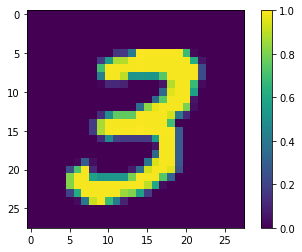

In [14]:
importlib.reload(data)
(x_train, y_train), (x_test, y_test) = data.load_data()

x_train, y_train = data.filter_36(x_train, y_train)
x_test, y_test = data.filter_36(x_test, y_test)

print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

True
Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


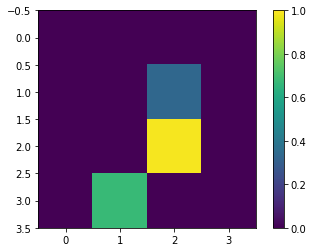

In [15]:
SCALED_SIZE = (4, 4)

# Downscaling
x_train_small = tf.image.resize(x_train, SCALED_SIZE).numpy()
x_test_small = tf.image.resize(x_test, SCALED_SIZE).numpy()

print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

x_train_nocon, y_train_nocon = data.remove_contradicting(x_train_small, y_train)

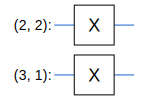

In [16]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

x_train_circ = [quantum.convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [quantum.convert_to_circuit(x) for x in x_test_bin]

SVGCircuit(x_train_circ[0])

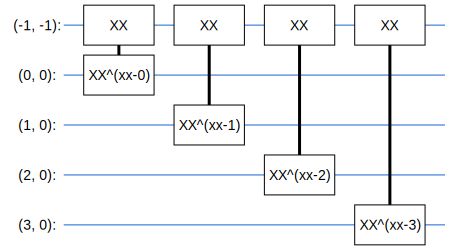

In [17]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

demo_builder = quantum.CircuitLayerBuilder(
    data_qubits = cirq.GridQubit.rect(4,1),
    readout=cirq.GridQubit(-1,-1)
)

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [22]:
model_circuit, model_readout = quantum.create_quantum_model(SCALED_SIZE)

# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[machine_learning.hinge_accuracy])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_4 (PQC)                  (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


Training the model. This takes several minutes.

In [23]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
324/324 [==============================] - 60s 183ms/step - loss: 0.8588 - hinge_accuracy: 0.6866 - val_loss: 0.4491 - val_hinge_accuracy: 0.7873

Classical model for comparison

In [24]:
model = machine_learning.create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

Training the classical model

In [25]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

62/62 [==============================] - 3s 29ms/step - loss: 0.0021 - accuracy: 0.9995 


Classical model with similar restrictions as the quantum model

In [26]:
model = machine_learning.create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Epoch 1/20
81/81 - 0s - loss: 0.6926 - accuracy: 0.5249 - val_loss: 0.6809 - val_accuracy: 0.4868
Epoch 2/20
81/81 - 0s - loss: 0.6666 - accuracy: 0.5249 - val_loss: 0.6534 - val_accuracy: 0.4868
Epoch 3/20
81/81 - 0s - loss: 0.6332 - accuracy: 0.5249 - val_loss: 0.6135 - val_accuracy: 0.4868
Epoch 4/20
81/81 - 0s - loss: 0.5881 - accuracy: 0.5249 - val_loss: 0.5644 - val_accuracy: 0.4868
Epoch 5/20
81/81 - 0s - loss: 0.5399 - accuracy: 0.5249 - val_loss: 0.5195 - val_accuracy: 0.4868
Epoch 6/20
81/81 - 0s - loss: 0.4952 - accuracy: 0.5249 - val_loss: 0.4780 - val_accuracy: 0.4868
Epoch 7/20
81/81 - 0s - loss: 0.4558 - accuracy: 0.5249 - val_loss: 0.4441 - val_accuracy: 0.4868
Epoch 8/20
81/81 - 0s - loss: 0.4248 - accuracy: 0.7092 - val_loss: 0.4161 - val_accuracy: 0.7937
Epoch 9/20
81/81 - 0s - loss: 0.3996 - accuracy: 0.8205 - val_loss: 0.3920 - val_accuracy: 0.7998
Epoch 10/20
81/81 - 0s - loss: 0.3783 - accuracy: 0.8251 - val_loss: 0.3711 - val_accuracy: 0.8059
Epoch 11/20
81/81 -

/home/mika/Git/fys2029-project/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

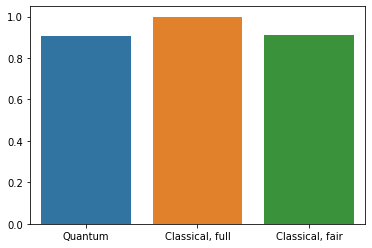

In [28]:
# Comparison
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])